In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

/home/ekoenig/mambaforge/envs/studies/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from utils.genprodUtils.generators import Generator
from utils.genprodUtils import two_body_decay

class Generator(Generator):
    def valid(self, event):
        self.jet_mass = np.random.lognormal( np.log(10), 0.5, size=(2, len(event)) )
        mask = event.mass > self.jet_mass.sum(axis=0)

        self.jet_mass = self.jet_mass[:,mask]
        return mask
    
    def physics(self, event):
        j1, j2 = two_body_decay(event, *self.jet_mass)
        jets = ak.concatenate([j1[:,None], j2[:,None]], axis=1)
        return dict(jet=jets)

In [3]:

gen_sig = lambda m : Generator(dict(
    pt=lambda n : np.random.lognormal(np.log(100), 1, n),
    eta=lambda n : np.random.uniform(-2.5, 2.5, n),
    phi=lambda n : np.random.uniform(-np.pi, np.pi, n),
    mass=lambda n : np.random.normal(m, 0.1*m, n),
))

masses = [100, 150, 200]
gen_sig = { m : gen_sig(m) for m in masses }

gen_bkg = Generator(dict(
    pt=lambda n : np.random.lognormal(np.log(100), 1, n),
    eta=lambda n : np.random.uniform(-2.5, 2.5, n),
    phi=lambda n : np.random.uniform(-np.pi, np.pi, n),
    mass=lambda n : np.random.lognormal( np.log(100), 1, n),
))


In [242]:
signal = ObjIter([ Tree.from_ak(gen(10000), sample=f'mass={m}', is_signal=True) for m, gen in gen_sig.items() ])
bkg = ObjIter([ Tree.from_ak(gen_bkg(3*10000), sample='bkg', color='lightgrey') ])

0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]

[WARNING] unable to open any files with filelist
           []


100%|██████████| 4/4 [00:00<00:00, 12.05it/s]


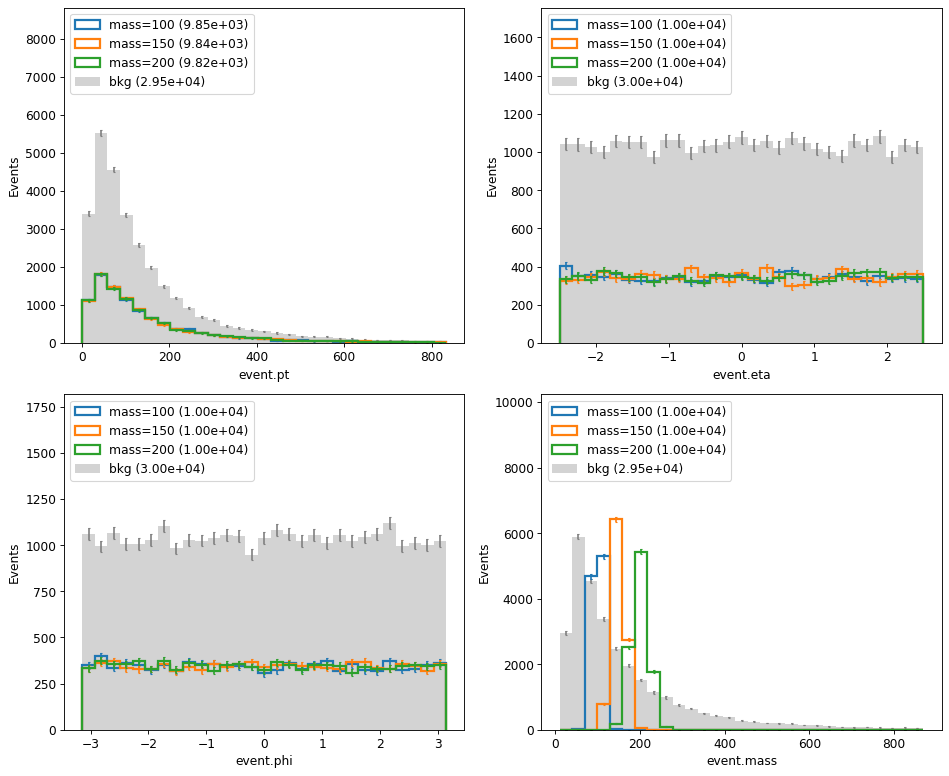

In [243]:
study.quick(
    signal + bkg, 
    varlist=['event.pt','event.eta','event.phi','event.mass'],
    lumi=None,
    legend=True,
)

100%|██████████| 4/4 [00:00<00:00,  6.78it/s]


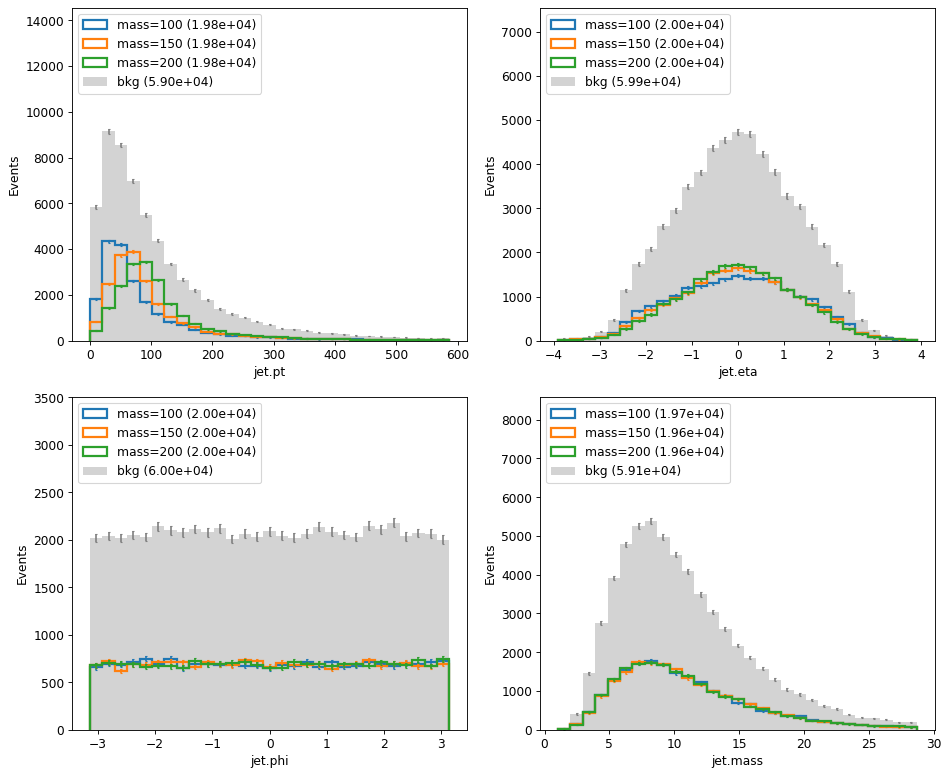

In [244]:
study.quick(
    signal + bkg, 
    varlist=['jet.pt','jet.eta','jet.phi','jet.mass'],
    lumi=None,
    legend=True,
)

In [245]:
from torch.utils.data import DataLoader, Dataset

class Dataset(Dataset):
    def __init__(self, parameters, inputs, targets):
        self.parameters = torch.from_numpy(parameters).float()
        self.inputs = torch.from_numpy(inputs).float()
        self.targets = torch.from_numpy(targets).long()
        
    def __len__(self): return len(self.parameters)
        
    def __getitem__(self, idx):
        return dict(
            parameters=self.parameters[idx], 
            inputs=self.inputs[idx], 
            targets=self.targets[idx]
        )
        
def get_parameters(tree):
    parameters = []
    for feature in ['event.mass']:
        parameters.append( tree[feature][:,None] )
        
    parameters = ak.concatenate(parameters, axis=1)
    return ak.to_numpy(parameters)

def get_inputs(tree):
    inputs = []
    for feature in ['jet.pt','jet.eta','jet.phi','jet.mass']:
        inputs.append( tree[feature][:,None] )
        
    inputs = ak.concatenate(inputs, axis=1)
    inputs = ak.flatten(inputs, axis=2)
    
    return ak.to_numpy(inputs)

def get_targets(tree):
    return np.ones(len(tree), dtype=np.int64) * tree.is_signal


In [246]:
import torch 

class Cluster(torch.nn.Module):
    def __init__(self, n_clusters, n_features, n_embedding=16):
        super().__init__()
        self.n_clusters = n_clusters
        self.n_features = n_features
        self.n_embedding = n_embedding
        
        self.batch_norm = torch.nn.BatchNorm1d(n_features)
        self.embeddings = torch.nn.Embedding(n_clusters, n_embedding)
        self.clusters = self.embeddings(torch.arange(n_clusters)).unsqueeze(0)
        
        self.linear = torch.nn.Linear(n_features, n_embedding)
        
    def predict(self, x):
        x = self.batch_norm(x)
        x = self.linear(x).unsqueeze(1)
        chi2 = torch.sum( (x - self.clusters)**2, axis=-1 )
        return torch.argmin(chi2, axis=-1)
    
    def forward(self, x):
        return self.embeddings( self.predict(x) )

In [286]:
class Classifier(torch.nn.Module):
    def __init__(self, nfts, layers=[], nclasses=2):
        super().__init__()
        self.nfts = nfts
        self.nclasses = nclasses
        self.layers = torch.nn.ModuleList([
            torch.nn.Linear(nfts, layers[0]),
            *[ torch.nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1) ],
            torch.nn.Linear(layers[-1], nclasses),
        ])
        self.act = torch.nn.Sigmoid()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.act(layer(x))
        return self.layers[-1](x)

In [287]:
from typing import Any
import pytorch_lightning as pl

class ParametericClassifier(pl.LightningModule):
    def __init__(self, nparams, nbits, nfts, nembed, layers, nclasses=2, lr=1e-3):
        super().__init__()
        self.named_parameters
        self.nclasses = nclasses
        self.lr = lr
        
        self.batch_norm = torch.nn.BatchNorm1d(nfts)
        self.embedding = torch.nn.Linear(nfts, nembed)
        self.clusters = Cluster(nbits, nparams, nembed)
        
        self.classifier = Classifier(nembed, layers, nclasses)
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, m, x):
        x = self.clusters(m) + self.embedding(x)
        return self.classifier(x)
    
    def predict(self, m, x):
        x = self.cluster.embeddings(m) + self.embedding(x)
        return self.classifier(x)

    def training_step(self, batch, idx):
        m = batch['parameters'].float()
        x = batch['inputs'].float()
        y = batch['targets']
        
        logits = self(m, x)
        loss = self.loss(logits, y)
        
        probs = torch.softmax(logits, axis=-1)
        y_hat = torch.argmax(probs, axis=-1)
        
        accuracy = torch.sum(y_hat == y).float() / len(y)
        
        self.log('loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=False)
        self.log('accuracy', accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=False)
        return loss
    
    def configure_optimizers(self) -> Any:
        return torch.optim.Adam(self.parameters(), lr=self.lr)
        
        

In [288]:
parameters = (signal + bkg).apply(get_parameters).cat.to_numpy()
inputs = (signal + bkg).apply(get_inputs).cat.to_numpy()
targets = (signal + bkg).apply(get_targets).cat.to_numpy()

In [289]:
dataset = Dataset(parameters, inputs, targets)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [295]:
model = ParametericClassifier(1, 3, 8, 16, [16, 32, 32, 16], 2)

In [296]:
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, train_dataloaders=loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type             | Params
------------------------------------------------
0 | batch_norm | BatchNorm1d      | 16    
1 | embedding  | Linear           | 144   
2 | clusters   | Cluster          | 82    
3 | classifier | Classifier       | 2.4 K 
4 | loss       | CrossEntropyLoss | 0     
------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 469/469 [00:03<00:00, 142.71it/s, v_num=8, loss=0.635, accuracy=0.634]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 469/469 [00:03<00:00, 142.39it/s, v_num=8, loss=0.635, accuracy=0.634]


(<Figure size 650x650 with 1 Axes>,
 <Axes: ylabel='Events'>,
 [HistoList<[<utils.plotUtils.histogram.Histo object at 0x7fb853b34d90>, <utils.plotUtils.histogram.Histo object at 0x7fb853b34af0>, <utils.plotUtils.histogram.Histo object at 0x7fb853b37b20>]>])

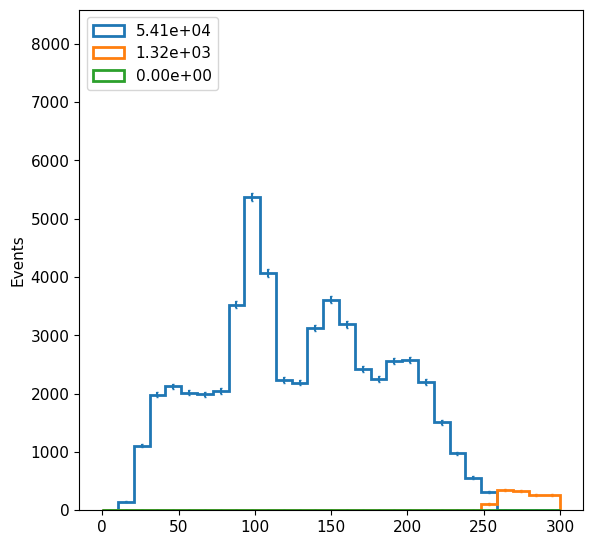

In [297]:
clusters = model.clusters.predict(torch.from_numpy(parameters).float())

hist_multi([ parameters[clusters == c] for c in np.arange(model.clusters.n_clusters) ], legend=True, bins=(0, 300, 30))